## Shift Planning Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\New folder\dataset\final_merged_output.csv")

In [3]:
# 2. Preprocess
df['StartTime'] = pd.to_datetime(df['StartTime'], errors='coerce')
df['EndTime'] = pd.to_datetime(df['EndTime'], errors='coerce')


In [4]:
# Drop rows with missing important fields
df = df.dropna(subset=['StartTime', 'EndTime', 'EmployeeID', 'Role'])


In [5]:
# Extract Week Start Date
df['ShiftWeek'] = df['StartTime'].dt.to_period('W').apply(lambda r: r.start_time)

In [6]:

# Group: Number of unique employees scheduled per week
weekly_employee_count = df.groupby('ShiftWeek')['EmployeeID'].nunique()
weekly_employee_count.index = pd.to_datetime(weekly_employee_count.index)

In [7]:
# Reindex (fill missing weeks)
full_index = pd.date_range(start=weekly_employee_count.index.min(), end=weekly_employee_count.index.max(), freq='W-MON')
weekly_employee_count = weekly_employee_count.reindex(full_index)
weekly_employee_count = weekly_employee_count.interpolate(method='time')

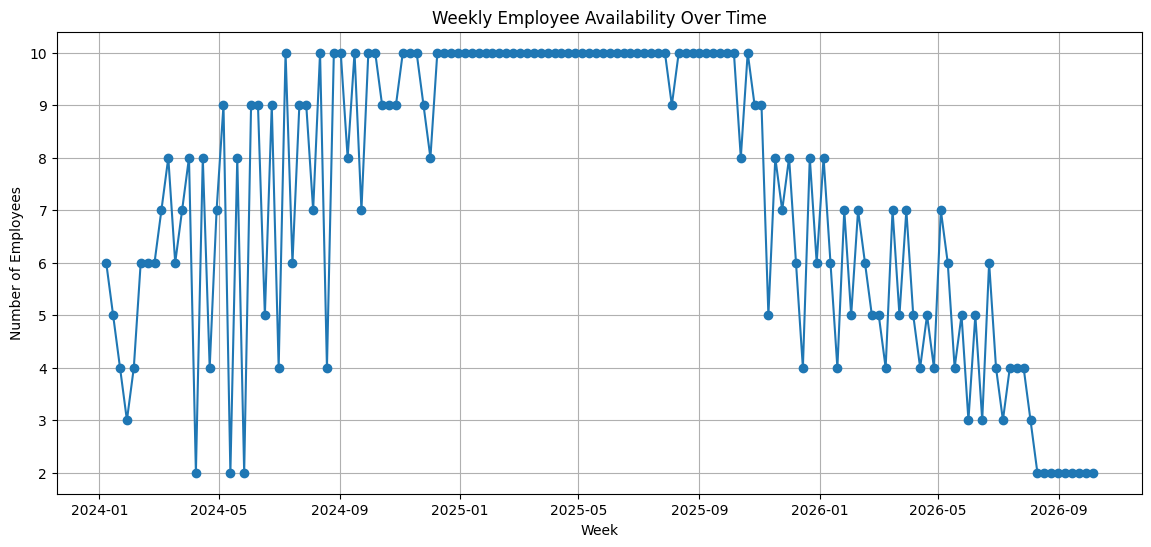

In [8]:
# 3. Visualize
plt.figure(figsize=(14,6))
plt.plot(weekly_employee_count, marker='o')
plt.title('Weekly Employee Availability Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Employees')
plt.grid(True)
plt.show()


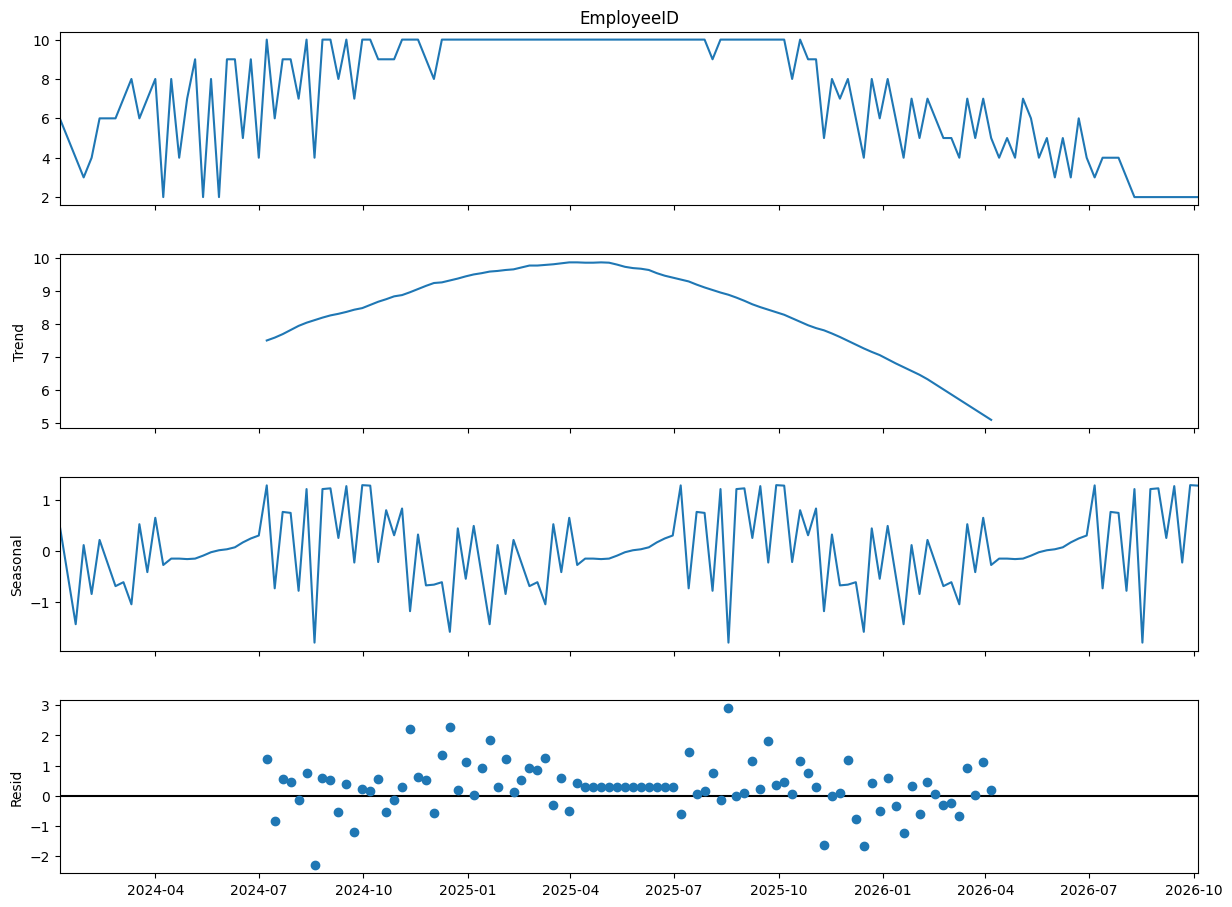

In [9]:
# 4. Decompose Time Series (Trend + Seasonality)
decomposition = seasonal_decompose(weekly_employee_count, model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()


In [10]:
# 5. ADF Test for Stationarity
result = adfuller(weekly_employee_count)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.349946
p-value: 0.979523


In [11]:
# 6. Differencing if not stationary
need_diff = False
if result[1] > 0.05:
    print("Series is not stationary. Applying differencing...")
    ts_to_model = weekly_employee_count.diff().dropna()
    need_diff = True
else:
    print("Series is stationary.")
    ts_to_model = weekly_employee_count
    

Series is not stationary. Applying differencing...


In [22]:
# 7. Train-Test Split
train_size = int(len(ts_to_model) * 0.8)
train, test = ts_to_model[:train_size], ts_to_model[train_size:]


In [23]:
# 8. Train SARIMA Model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52))
model_fit = model.fit(disp=False)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [24]:
# 9. Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

In [19]:
# If differencing was applied, adjust forecast
if need_diff:
    last_train_value = weekly_employee_count.iloc[train_size-1]
    forecast = last_train_value + forecast.cumsum()

In [26]:
# 10. Calculate Performance Metrics
true_test = weekly_employee_count.iloc[train_size:train_size+forecast_steps]
mae = mean_absolute_error(true_test, forecast)
mse = mean_squared_error(true_test, forecast)
rmse = np.sqrt(mse)

In [27]:
# Calculate performance metrics again
mae = mean_absolute_error(true_test, forecast)
mse = mean_squared_error(true_test, forecast)
rmse = np.sqrt(mse)


In [28]:

print("\nModel Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance on Test Data:
Mean Absolute Error (MAE): 4.21
Mean Squared Error (MSE): 25.47
Root Mean Squared Error (RMSE): 5.05
